In [1]:
import os
import csv
import cv2
import random

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

# For Visualization
import matplotlib.pyplot as plt
import pickle 

Data Generator

In [2]:
class DrivingDataGenerator(Sequence):
    def __init__(self, csv_file, batch_size=64, shuffle=True):
        self.samples = []
        with open(csv_file) as f:
            reader = csv.reader(f)
            for line in reader:
                self.samples.append(line)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()


    def __len__(self):
        return len(self.samples) // self.batch_size


    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.samples)


    def __getitem__(self, index):
        batch_samples = self.samples[index*self.batch_size:(index+1)*self.batch_size]
        images, angles = [], []
        for sample in batch_samples:
            center, left, right, steering, throttle, brake, speed = sample
            steering = float(steering)
            offset = 0.333


            cameras = [(center, steering),
            (left, steering + offset),
            (right, steering - offset)]


            for img_path, angle in cameras:
                if not os.path.exists(img_path):
                    continue
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # Crop: remove 75px from top, 25px from bottom (same as Cropping2D((75,25)))
                img = img[75:135, :, :]
                img = cv2.resize(img, (320, 60))
                img = img.astype(np.float32) / 255.0
                images.append(img)
                angles.append(angle)


        X = np.array(images)
        y = np.array(angles)
        return X, y

Model Definition

In [3]:
def build_self_driving_model():
    model = tf.keras.Sequential([
        layers.Input(shape=(60, 320, 3)),
        layers.Conv2D(24, (5,5), strides=(2,2), activation='relu', padding='same'),
        layers.Conv2D(36, (5,5), strides=(2,2), activation='relu', padding='same'),
        layers.Conv2D(48, (5,5), strides=(2,2), activation='relu', padding='same'),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(50, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='relu'),
        layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse')
    return model


Training Pipeline

In [4]:
#Configuration of the Pipeline
CSV_PATH = 'data/driving_log.csv'
MODEL_PATH = 'saved_model.keras'
EPOCHS = 10
BATCH_SIZE = 64

#Splitting 
df = pd.read_csv(CSV_PATH, header=None)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

train_csv = 'train_log.csv'
val_csv = 'val_log.csv'
train_df.to_csv(train_csv, index=False, header=False)
val_df.to_csv(val_csv, index=False, header=False)

train_gen = DrivingDataGenerator(train_csv, batch_size=BATCH_SIZE, shuffle=True)
val_gen = DrivingDataGenerator(val_csv, batch_size=BATCH_SIZE, shuffle=False)

model = build_self_driving_model()
model.summary()


# Training the model and storing History data for Loss Validation
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    verbose=1
)


model.save(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

with open("training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)
print("Training history saved to training_history.pkl")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 160, 24)    │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 15, 80, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 40, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 40, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 40, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     2,048,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,185,019 (8.34 MB)

 Trainable params: 2,185,019 (8.34 MB)

 Non-trainable params: 0 (0.00 B)

c:\Users\Johnson Prince\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 218ms/step - loss: 0.0735 - val_loss: 0.0433
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - loss: 0.0478 - val_loss: 0.0312
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/step - loss: 0.0399 - val_loss: 0.0284
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 255ms/step - loss: 0.0358 - val_loss: 0.0247
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 248ms/step - loss: 0.0341 - val_loss: 0.0244
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 254ms/step - loss: 0.0329 - val_loss: 0.0251
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 251ms/step - loss: 0.0315 - val_loss: 0.0231
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 252ms/step - loss: 0.0307 - val_loss: 0.0230
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 246ms/step - loss: 0.0292 - val_loss: 0.0219
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 249ms/step - loss: 0.0288 - val_loss: 0.0222
Model saved to saved_model.keras
Training history saved to training_history.pkl


PLT Loss Curve

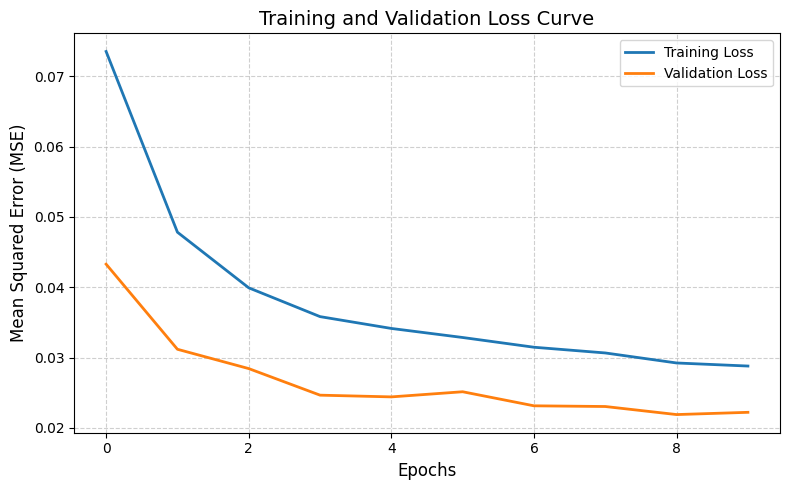

In [5]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss Curve', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('loss_curve.png', dpi=300)
plt.show()